In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

All the datasets used in this text are available online at
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

Bayesian Methods for Hackers is designed as an introduction to Bayesian inference from a computational/understanding first, and mathematics second, point of view. Of course, as an introductory book, we can only leave it at that: an introductory book. For the mathematically trained, the curiosity this text generates may be cured by other texts designed with mathematical analysis in mind. For the enthusiast with a less mathematical background, or one who is not interested in the mathematics but simply the practice of Bayesian methods, this text should be sufficient and entertaining.


The choice of PyMC as the probabilistic programming language is twofold. First, as of this writing, there is currently no central resource for examples and explanations in the PyMC universe. The official documentation assumes prior knowledge of Bayesian inference and probabilistic programming. We hope this book encourages users at every level to look at PyMC. Second, with recent core developments and popularity of the scientific stack in Python, PyMC is likely to become a core component soon enough.


The progression of the book is as follows. Chapter 1 introduces Bayesian inference and its comparison to other inference techniques. We also see, build, and train our first Bayesian model. Chapter 2 focuses on building models with PyMC, with a strong emphasis on examples. Chapter 3 introduces Markov Chain Monte Carlo, a powerful algorithm behind computational inference, and some techniques on debugging your Bayesian model. In Chapter 4, we detour and again visit the issue of sample sizes in inference and explain why understanding sample size is so important. Chapter 5 introduces the powerful idea of loss functions, where we have not a model but a function that connects inference to real-world problems. We revisit the idea of Bayesian priors in Chapter 6, and give good heuristics to picking good priors. Finally, in Chapter 7, we explore how Bayesian inference can be used in A/B testing.





### The Philosophy of Bayesian Inference

If you think this way, then congratulations: You already are thinking Bayesian! Bayesian inference is simply updating your beliefs after considering new evidence. A Bayesian can rarely be certain about a result, but he or she can be very confident. Just like in the example above, we can never be 100% sure that our code is bug-free unless we test it on every possible problem, something rarely possible in practice. Instead, we can test it on a large number of problems, and if it succeeds, we can feel more confident about our code, but still not certain. Bayesian inference works identically: We update our beliefs about an outcome, but rarely can we be absolutely sure unless we rule out all other alternatives.

Bayesian inference differs from more traditional statistical inference by preserving uncertainty. At first, this sounds like a bad statistical technique. Isn’t statistics all about deriving certainty from randomness? To reconcile this, we need to start thinking like Bayesians.
The Bayesian worldview interprets probability as measure of believability in an event—that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability.

For this to be clearer, we consider an alternative interpretation of probability: Frequentists, who ascribe to the more classical version of statistics, assume that probability is the long-run frequency of events (hence the name). For example, the probability of plane accidents under a frequentist philosophy is interpreted as the long-term frequency of plane accidents. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: We often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying that across all these realities, the frequency of occurrences defines the probability.

Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as the measure of belief, or confidence, in an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event believes with absolute certainty that the event will not occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain that the event will occur. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the example of the probability of a plane accident occurring, for having observed the frequency of plane accidents, an individual’s belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: How confident are you that candidate A will win?

Notice that in the preceding paragraph, I assigned the belief (probability) measure to an individual, not to nature. This is very interesting, as this definition leaves room for conflicting beliefs between individuals. Again, this is analogous to what naturally occurs: Different individuals have different beliefs of events occurring because they possess different information about the world. The existence of different beliefs does not imply that anyone is wrong.

To align ourselves with traditional probability notation, we denote our belief about event A as P(A). We call this quantity the prior probability.

John Maynard Keynes, a great economist and thinker, is often quoted (perhaps apocryphally) as saying, “When the facts change, I change my mind. What do you do, sir?” This quotation reflects the way a Bayesian updates his or her beliefs after seeing evidence. Even—especially—if the evidence is counter to what was initially believed, the evidence cannot be ignored. We denote our updated belief as P(A|X), interpreted as the probability of A given the evidence X. We call the updated belief the posterior probability so as to contrast it with the prior probability.

As we acquire more and more instances of evidence, our prior belief is “washed out” by the new evidence. This is to be expected. For example, if your prior belief is something ridiculous like “I expect the sun to explode today,” and each day you are proved wrong, you would hope that any inference would correct you, or at least align your beliefs better. Bayesian inference will correct this belief.

Denote N as the number of instances of evidence we possess. As we gather an infinite amount of evidence, say as N → ∞, our Bayesian results (often) align with frequentist results. Hence for large N, statistical inference is more or less objective. On the other hand, for small N, inference is much more unstable; frequentist estimates have more variance and larger confidence intervals. This is where Bayesian analysis excels. By introducing a prior, and returning probabilities (instead of a scalar estimate), we preserve the uncertainty that reflects the instability of statistical inference of a small-N dataset.


One may think that for large N, one can be indifferent between the two techniques since they offer similar inference, and might lean toward the computationally simpler frequentist methods. An individual in this position should consider the following quotation by Andrew Gelman (2005)[1] before making such a decision:
Sample sizes are never large. If N is too small to get a sufficiently-precise estimate, you need to get more data (or make more assumptions). But once N is “large enough,” you can start subdividing the data to learn more (for example, in a public opinion poll, once you have a good estimate for the entire country, you can estimate among men and women, northerners and southerners, different age groups, etc). N is never enough because if it were “enough” you’d already be on to the next problem for which you need more data.


The much more difficult analytic problems involve medium data and—especially troublesome—really small data. Using an argument similar to Gelman’s, if big-data problems are big enough to be readily solved, then we should be more interested in the not-quite-big-enough datasets.


## Our Bayesian Framework

We are interested in beliefs, which can be interpreted as probabilities by thinking Bayesian. We have a prior belief in event A - for example, our prior belief about bugs being in our code before performing tests.

Next, we observe our evdience. To continue our buggy-code example: If our code passes X tests, we want ot update our belief to incorporate this. We cann this new belief the _posterior probability_. Updating our belief is done via the following equation, known as Bayes's Theorem, after its discoverer Thomas Bayes:

$
P(A|X) = \frac{P(X|A)P(A)}{P(X)} \propto P(X|A)P(A)
$

In [4]:
242./500

0.484

In [6]:
top = (.95)*(1./21)
bot = (.95)*(1./21) + (20./21)*.5
tot = top/bot
print tot
print 1./21

0.0867579908676
0.047619047619


In [7]:
top = (.5)*(20./21)
bot = (.95)*(1./21) + (20./21)*.5
tot = top/bot
print tot
print 20./21

0.913242009132
0.952380952381


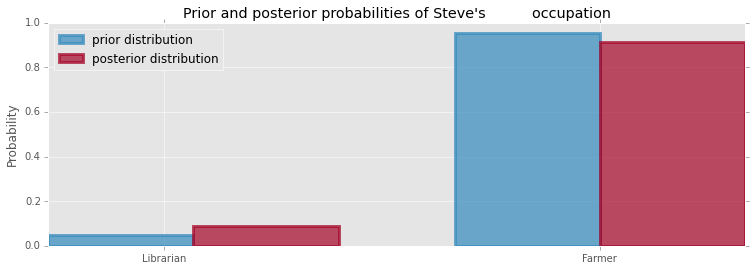

In [8]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(12.5, 4)
colors = ["#348ABD", "#A60628"]
prior = [1/21., 20/21.]
posterior = [0.087,1-0.087]
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
        color=colors[0], label="prior distribution",
        lw="3", edgecolor="#348ABD")

plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
        width=0.25, color=colors[1],
        label="posterior distribution",
        lw="3", edgecolor="#A60628")

plt.xticks([0.20, 0.95], ["Librarian", "Farmer"])
plt.title("Prior and posterior probabilities of Steve's\
          occupation")
plt.ylabel("Probability")
plt.legend(loc="upper left");

In [9]:
colors = ["#348ABD", "#A60628"]  # 

In [11]:
prior = [1/21., 20/21.]

In [6]:
import scipy.stats as stats

We say that $Z$ is Poisson-distributed if:

$
P(Z=k) = \frac{\lambda^{k} e^{-\lambda}}{k !}, k=0, 1, 2, \cdots
$


If a random variable $Z$ has a Poisson mass distribution, we denote this by writing

$ \lambda$ is called a parameter of the distribution, and it controls the distribution's shape.
For the Poisson distribution, $\lambda$ can be any positive number. 
By increasing $\lambda$, we add more probability to larger values; conversely, by descreasing
$\lambda$, we add more probability to smaller values. One can describe $\lambda$ as the _intensity_ of the 
Poisson distribution.

Unlike $\lambda$, which can be any positive number, the value $k$ in the preceding formula must be a non-negative
interger - that is, $k$ must take on values 0, 1, 2, and so on. This is very important, because if you want to model a
population, you cannot make sense of populations with 4.25 and 5.612 members.
If a random variable $Z$ has a Poisson mass distribution, we denote this by writing

$
Z \sim \mbox{Poi}(\lambda)
$

One useful property of the Poisson distibution is that its expected value is equal to its parameter.
That is,
$ 
E[Z|\lambda] = \lambda
$

Proof:

$
E[Z|\lambda] = \sum_{k=0,1,2} \frac{k \lambda^{k} e^{-\lambda}}{k !} = e^{-\lambda} \lambda \sum_{k=1,2} \frac{\lambda^{k}}{(k-1)!}
$

$ = e^{-\lambda} \lambda \sum_{k=1,2} \frac{\lambda^{k-1}}{(k-1)!} = e^{-\lambda} \lambda e^{+\lambda} = \lambda
$

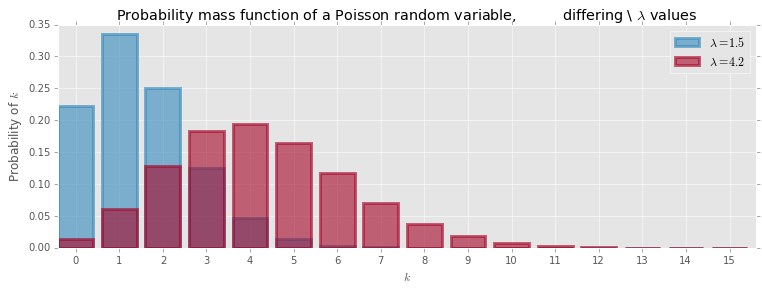

In [12]:
figsize(12.5, 4)
import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colors = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
        label="$\lambda = %.1f $" % lambda_[0], alpha=0.60,
        edgecolor=colors[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
        label="$\lambda = %.1f $" % lambda_[1], alpha=0.60,
        edgecolor=colors[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("Probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable,\
          differing \ $\lambda$ values");

In [13]:
a = np.arange(100)

In [14]:
poi = stats.poisson

In [15]:
duh = poi.pmf(a, 50)

In [16]:
duh

array([  1.92874985e-22,   9.64374924e-21,   2.41093731e-19,
         4.01822885e-18,   5.02278606e-17,   5.02278606e-16,
         4.18565505e-15,   2.98975361e-14,   1.86859601e-13,
         1.03810889e-12,   5.19054446e-12,   2.35933839e-11,
         9.83057663e-11,   3.78099101e-10,   1.35035393e-09,
         4.50117977e-09,   1.40661868e-08,   4.13711376e-08,
         1.14919827e-07,   3.02420597e-07,   7.56051492e-07,
         1.80012260e-06,   4.09118773e-06,   8.89388636e-06,
         1.85289299e-05,   3.70578598e-05,   7.12651151e-05,
         1.31972435e-04,   2.35665063e-04,   4.06319074e-04,
         6.77198457e-04,   1.09225558e-03,   1.70664934e-03,
         2.58583233e-03,   3.80269460e-03,   5.43242086e-03,
         7.54502897e-03,   1.01959851e-02,   1.34157699e-02,
         1.71997050e-02,   2.14996312e-02,   2.62190624e-02,
         3.12131696e-02,   3.62943832e-02,   4.12436173e-02,
         4.58262414e-02,   4.98111320e-02,   5.29905660e-02,
         5.51985062e-02,

In [17]:
duhseries = pd.Series(duh, index=a)

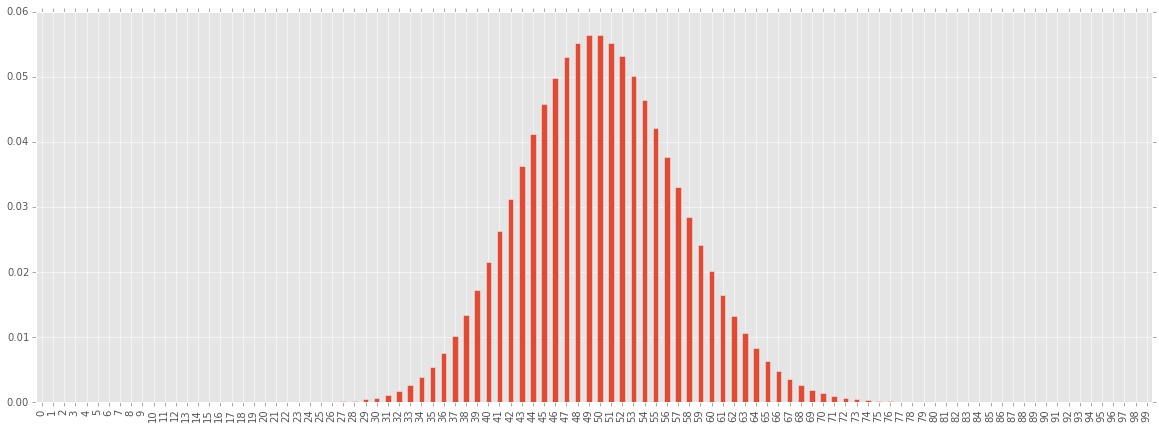

In [18]:
duhseries.plot(kind='bar',figsize=((20,7)))

An example of a continuous random variable is a random variable with _exponential density_. The density function for an exponential random variable looks like this:

$
\lambda e^{-\lambda z}, z \geq 0
$


Like a Poisson random variable, an exponential random variable can take on only non-negative values. 
But unlike a Poisson variable, the exponential can take on _any_ non-negative values, 
including non-integral values such as 4.25 or 5.612401. This property makes it a poor choice for count data, which must be 
an integer, but a great choice for time data, temperature data (measured in Kelvins, of course), or any other precise _and positive_ variable.

When a random variable Z has an exponential distribution with parameter $\lambda$, we say $Z$ is exponential and write
$
Z \sim \mbox{Exp}(\lambda)
$  

Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$. That is,

$
E[Z|\lambda] = \frac{1}{\lambda}
$


Proof:

$ 
E[ Z | \lambda ] = \int_{0}^{\infty} \lambda e^{-\lambda z} \mbox{dz} 
$

$
u = \lambda z \\
du = \lambda dz
$

$
E[ Z | \lambda ] = \int_{0}^{\infty} \frac{e^{-u} du}{\lambda} \\
  = \frac{1}{\lambda} ( - e^{-u} |^{\infty}_{0} = \frac{1}{\lambda}
$



In [19]:
a = np.linspace(0,4,300)
expo = stats.expon

In [20]:
supduh = expo.pdf(a, scale=1/4.)

In [21]:
dumsupduh = pd.Series(supduh, index=a)

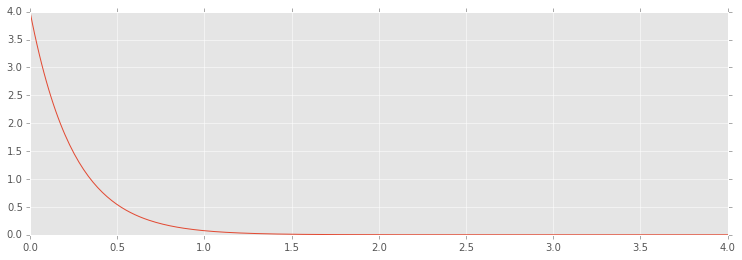

In [22]:
dumsupduh.plot()

C:\Users\ddooling\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


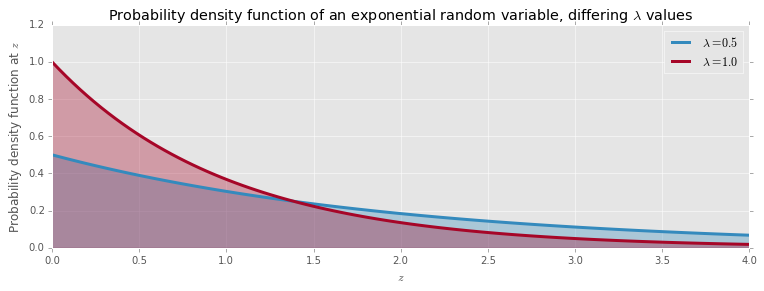

In [23]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f $" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("Probability density function at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an exponential random " + 
          "variable, differing $\lambda$ values");

## But what is $\lambda$?

This question is what motivates statistics. In the real world, $\lambda$ is hidden from us. We only see $Z$, and must work backward to try to determine $\lambda$. The problem is difficult becuase there is no one-to-one mapping from $Z$ to $\lambda$. Many different methods have been created to solve the problem of estimating $\lambda$, but since $\lambda$ is never actually observed, no can say for certain which method is best!

Bayesian inference is concerned with _beliefs_ about what $\lambda$ might be. Rather than trying to guess $\lambda$ exactly, we can only talk about what $\lambda$ is likely to be by assigning a probability distribution to $\lambda$. 

This might seem odd at first. After all, $\lambda$ is fixed; it is not (necessarily) random! How can we assign probabilities to values of a non-random variable? Uh-oh; we have fallen for our old, frequentist way of thinking. Recall that under Bayesian philsophy, we _can_ assign probabilities if we interpret them as beliefs. And it is entirely acceptable to have _beliefs_ about the parameter $\lambda$.


### Using Computers to Perform Bayesian Inference for Us

Example: Inferring Behavior from Text-Message Data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages.

You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears below.
You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddently. How can you model this?

In [24]:
count_data = np.loadtxt("data/txtdata.csv")

In [25]:
count_data

array([ 13.,  24.,   8.,  24.,   7.,  35.,  14.,  11.,  15.,  11.,  22.,
        22.,  11.,  57.,  11.,  19.,  29.,   6.,  19.,  12.,  22.,  12.,
        18.,  72.,  32.,   9.,   7.,  13.,  19.,  23.,  27.,  20.,   6.,
        17.,  13.,  10.,  14.,   6.,  16.,  15.,   7.,   2.,  15.,  15.,
        19.,  70.,  49.,   7.,  53.,  22.,  21.,  31.,  19.,  11.,  18.,
        20.,  12.,  35.,  17.,  23.,  17.,   4.,   2.,  31.,  30.,  13.,
        27.,   0.,  39.,  37.,   5.,  14.,  13.,  22.])

In [26]:
countdataseries = pd.Series(count_data)

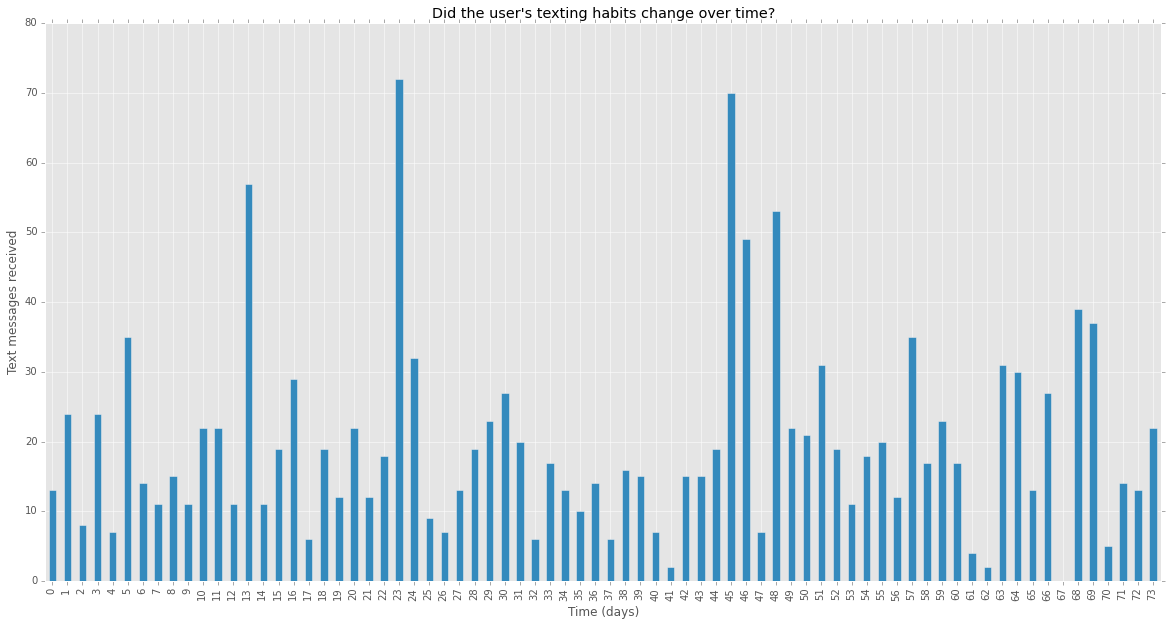

In [27]:
countdataseries.plot(kind='bar',figsize=(20,10),color="#348ABD",
                    title="Did the user's texting habits change over time?")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")


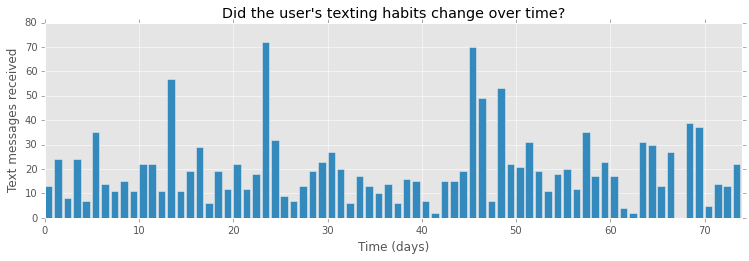

In [28]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Before we start modeling, see what you can figure out just by looking at Figure 1.4.1. Would you say there was a change in behavior during this time period?

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of count data. Denoting day i’s text-message count by Ci,

$
C_{i} \sim \mbox{Poi}(\lambda)
$

We are not sure what the value of the λ parameter really is, however. Looking at Figure 1.4.1, it appears that the rate might become higher late in the observation period, which is equivalent to saying that λ increases at some point during the observations. (Recall that a higher value of λ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)


How can we represent this observation mathematically? Let’s assume that on some day during the observation period (call it τ), the parameter λ suddenly jumps to a higher value. So we really have two λ parameters: one for the period before τ, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:



If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$'s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible vlaues of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the _exponential_ distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $a$.

$
\lambda_1 \sim Exp(a) \\
\lambda_1 \sim a e^{-a \lambda_1}
\lambda_2 \sim Exp(a) \\
\lambda_2 \sim a e^{-a \lambda_2}
$


$a$ is called a _hyperparameter_ or _parent variable_. In literal terms, it is a parameter that influences other parameters. Our initial guess at $a$ does not influence the model too strongly, so we have some flexibility in our choice. In our model, we don't want to be too opinionated with this parameter. I suggest setting it to the inverse of the sample average of the count data. Why? Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$
\frac{1}{N} \sum_{i=0}^{N} C_{i} \approx E[ \lambda | \alpha ] = \frac{1}{\alpha}
$

By using this value, we are not being very opinionated in our prior, and this minimizes the influence of this hyperparameter. An alternative option, and something I encourage the reader to try, would be to have two priors, one for each $\lambda_i$. 
Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some during the observations.

What about $\tau$? Becuase of the noisiness of the data, it's difficult to pick out a prior when $\tau$ might have occurred. Instead, we can assign a _uniform prior belief_ to every possible day. This is equivalent to saying

$
\tau \sim \mbox{DiscreteUniform}(1, 70) \\
P(\tau = k) = \frac{1}{70}
$

So after all this, what does our overall prior distribution for the unknown variables look like?
Frankly, _it doesn't matter_. What we should understand is that it's an ugly, complicated mess involving symbols only a mathematician could love. And things will only get uglier the more complicated our models become. REgardnelss, all we really care about is the posterior distribution.


PyMC is a Python library for programming Bayesian analysis.[5] It is a fast, well-maintained library. The only unfortunate part is that its documentation is lacking in certain areas, especially those that bridge the gap between beginner and hacker. One of this book’s main goals is to solve that problem, and also to demonstrate why PyMC is so cool.

We will model this problem using PyMC. This type of programming is called probabilistic programming, an unfortunate misnomer that invokes ideas of randomly generated code and has likely confused and frightened users away from this field. The code is not random; it is probabilistic in the sense that we create probability models using programming variables as the model’s components. Model components are first-class primitives within the PyMC framework.

PyMC code is easy to read. The only novel thing should be the syntax, and I will interrupt the code to explain individual sections. Simply remember that we are representing the model’s components (τ, λ1, λ2) as variables:


In [29]:
import pymc as pm
alpha = 1.0/count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [31]:
print alpha
alpha1 = 1./count_data[:40].mean()
alpha2 = 1./count_data[40:].mean()
print alpha1
print alpha2

0.0506502395619
0.0539811066127
0.0472222222222


In [32]:
import pymc as pm
alpha = 1.0/count_data.mean()
alpha1 = 1./count_data[:40].mean()
alpha2 = 1./count_data[40:].mean()
lambda_1 = pm.Exponential("lambda_1", alpha1)
lambda_2 = pm.Exponential("lambda_2", alpha2)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In this code, we create PyMC variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC's 
_stochastic variables_, so called because they are treated by the back end as random number generators. We can demonstrate this fact by calling their built-in ```random()``` methods. During the training step, we will find better values for ```tau```.

In [38]:
print "Random output for tau:", tau.random(), tau.random(), tau.random() 
print "Random output for lambda_1:", lambda_1.random(), lambda_1.random(), lambda_1.random()
print "Random output for lambda_2:", lambda_2.random(), lambda_2.random(), lambda_2.random()

Random output for tau: 22 58 17
Random output for lambda_1: 5.32607489482 7.41759173772 0.50840134006
Random output for lambda_2: 1.26077113528 19.7129717866 21.6959319253


In [61]:
import pymc as pm
n_count_data = len(count_data)

In [62]:
alpha = 1.0/count_data.mean()  # Recall that count_data is the 
                               # variable that holds our text counts. 

alpha1 = 1./count_data[:40].mean()
alpha2 = 1./count_data[40:].mean()
    
    
lambda_1 = pm.Exponential("lambda_1", alpha1)
lambda_2 = pm.Exponential("lambda_2", alpha2)

tau = pm.DiscreteUniform("tau", lower=0, upper=len(count_data))

In [64]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data) # number of data points 
    out[:tau] = lambda_1  # lambda before tau is lambda_1 
    out[tau:] = lambda_2  # lambda after (and including) tau is 
                          # lambda_2 
    return out

This code creates a new function ```lambda_```, but really we can think of it as a random variable - the random variable $\lambda$ from before. Notice that because ```lambda_1```, ```lambda_2```, and ```tau``` are random, ```lambda_``` will be random. We are _not_ fixing any variables yet.

```@pm.deterministic``` is a decorator that tells PyMC that it is a deterministic function. That is, if the arguments were deterministic (which they are not), the output would be deterministic as well.

In [65]:
observation = pm.Poisson("obs", lambda_, value=count_data,
                         observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

The variable ```obsevation``` combines our data, ```count_data```, with our proposed data-generation scheme, given by the variable ```lambda_```, through the ```value``` keyword. We also set ```observed = True``` to tell PyMC that this should stay fixed in our analysis. Finally, PyMC wants us to collect all the variables of interest and create a ```Model``` instance out of them. This makes ou rlife easier when we retrieve the results. 

The following code will be explained in Chapter 3, but I show it here so you can see where our results come from. 
One can think of it as a _learning_ step. The machinery being employed is called _Markov Chain Monte Carlo (MCMC)_, which I will explain in Chapter 3. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$, and $\tau$.  We can plot a histogram of the random variables to see what the posterior distributions look like. 
Next, we collect the samples (called ```traces``` in the MCMC literature) into histograms.

In [66]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 3.6 sec

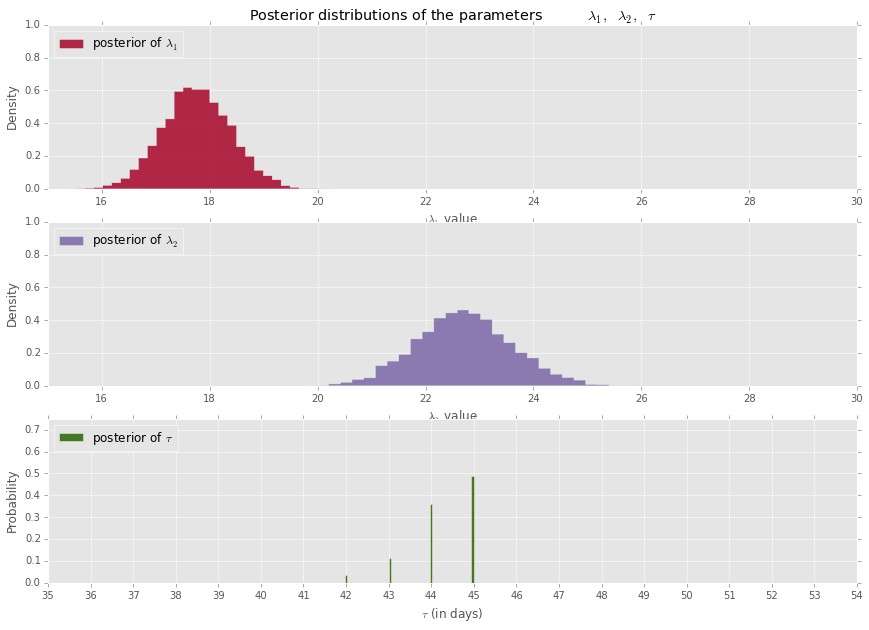

In [67]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

fig = plt.figure(figsize=(14.5,10))

#figsize(14.5, 10)
# histogram of the samples 

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters\
          $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability");

### 1.7 Exercises

In [68]:
lambda_1_samples.mean()

17.75919314626999

In [69]:
lambda_2_samples.mean()

22.715684766498036

In [70]:
((lambda_2_samples - lambda_1_samples) / lambda_1_samples ).mean()

0.28072549389047474

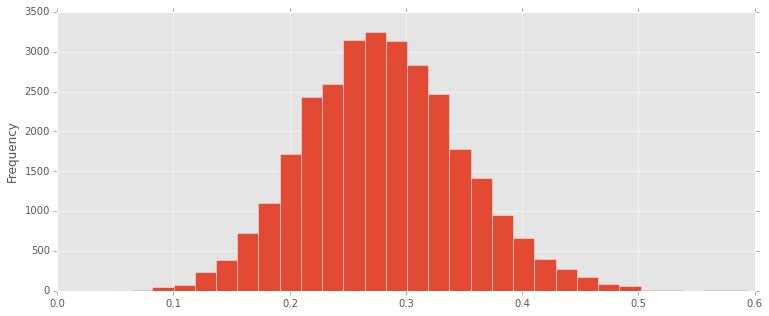

In [71]:
relative_increase_samples = (lambda_2_samples - lambda_1_samples) / lambda_1_samples

rel = pd.Series(relative_increase_samples)
rel.plot(kind='hist',bins=30)

In [72]:
ix = tau_samples < 45
print lambda_1_samples[ix].mean()

17.7444227237


### Interpretation

Recall that Bayesian methodology returns a _distribution_. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see that the plausible values for the parameters are:
$\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behavior.

What other observations can you make? If you look at the orginal data again, do these results seem reasonable?


Notice also that the posterior distributions for the $lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distribtions are not really of any form that we recognize from the orginal model. But that's okay! This is one of the benefits of taking a compuatational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computaional approach makes us indifferent to mathematical intractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behavior changed.

In [47]:
count_data[:45].mean()

17.755555555555556

In [45]:
lambda_1_samples.mean()

17.761967769800908

In [48]:
count_data[45:].mean()

22.827586206896552

In [49]:
lambda_2_samples.mean()

22.71527974230511

In [50]:
((lambda_2_samples - lambda_1_samples)/lambda_1_samples).mean()

0.28048672285878529

In [51]:
ix = tau_samples < 45
print lambda_1_samples[ix].mean()

17.7679836671


## What good are samples from the posterior, anyway?

We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some powerful results. For now, let's end this chapter with one more example.

We'll use the posterior samples to answer the following question: What is the expected number of texts at day t, $0 \leq t \leq 70$?
Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$.

In [73]:
tau_samples.shape[0]

30000L

[ 17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.75919315  17.75919315  17.75919315  17.75919315
  17.75919315  17.7632992   17.92584063  18.45015082  20.25970616
  22.71568477  22.71568477  22.71568477  22.71568477  22.71568477
  22.71568477  22.71568477  22.71568477  22.71568477  22.71568477
  22.71568477  22.71568477  22.71568477  22.71568477  22.71568477
  22.71568477  22.71568477  22.71568477  22.71568477  22.71568477
  22.71568477  22.71568477  22.71568477  22.71568477  22.71568477
  22.71568477  22.71568477  22.71568477  22.71568477]


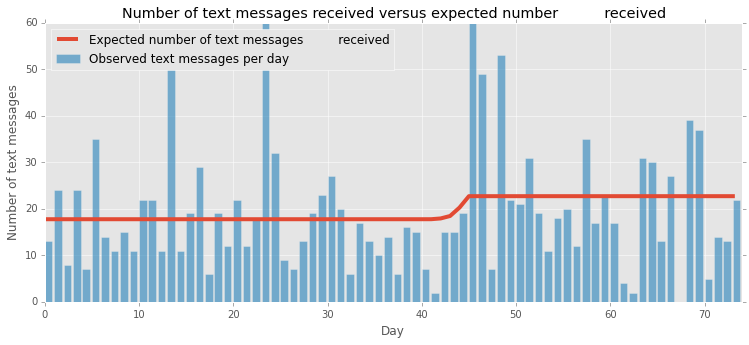

In [74]:
figsize(12.5, 5)
    # tau_samples, lambda_1_samples, lambda_2_samples contain 
    # N samples from the corresponding posterior distribution. 
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data) # number of data points 
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to 
    # the switchpoint occurring prior to value of "day." 
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau. 
    # For each day, that value of tau indicates whether we're 
    # "before" 
    # (in the lambda_1 "regime") or 
    # "after" (in the lambda_2 "regime") the switchpoint. 
    # By taking the posterior sample of lambda_1/2 accordingly,
    # we can average 
    # over all samples to get an expected value for lambda on that day. 
    # As explained, the "message count" random variable is 
    # Poisson-distributed, 
    # and therefore lambda (the Poisson parameter) is the expected 
    # value of 
    # "message count." 
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()\
                                   + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4,
         color="#E24A33", label="Expected number of text messages\
         received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Number of text messages")
plt.title("Number of text messages received versus expected number\
          received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD",
        alpha=0.65, label="Observed text messages per day")
plt.legend(loc="upper left")
print expected_texts_per_day



### Determining Statistically if the Two $\lambda$s are indeed different?

In the text-messaging example, we visually inspected the posteriors of $\lambda_1$ and $\lambda_2$ to declare them different.
This was fair, as the general locations of the posteriors were very far apart. What if this were not true? What if the distributions partially overlapped? How can we make this decision more formal?

One way is to compute $P( \lambda_1 < \lambda_2 | data )$; that is, what is the probability tha thte true value of $\lambda_1$ is smaller than $\lambda_2$, given the data we observed? If this number is close to 50%, no better than flipping a coin, then we can't be certain they are indeed different. If this number is close to 100%, then we can be very confident that the two true values are very different. Using samples from the posteriors, this computation is very simple - we compute the fraction of times that a sample from the posterior of $\lambda_1$ is less than one from $\lambda_2$:

In [75]:
print (lambda_1_samples < lambda_2_samples)

[ True  True  True ...,  True  True  True]


In [76]:
print (lambda_1_samples < lambda_2_samples).sum()

30000


In [77]:
print lambda_1_samples.shape[0]

30000


In [78]:
print (lambda_1_samples < lambda_2_samples).mean()

1.0


So, there is virtually a 100% chance, and we can be very confident the two values are different.

We can ask more complicated things, too, like "what is the probability that the values differ by least 1,? 2? 5? or 10?"

In [79]:
# The vector abs(lambda_1_samples - lambda_2_samples) > 1 is a boolean, 
# True if the values are more than 1 apart, False otherwise. 
# How often does this happen? Use .mean() 
for d in [1,2,5,10]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print "What is the probability the difference is larger than %d \
          ? %.2f "%(d,v)

What is the probability the difference is larger than 1           ? 1.00 
What is the probability the difference is larger than 2           ? 1.00 
What is the probability the difference is larger than 5           ? 0.48 
What is the probability the difference is larger than 10           ? 0.00 


In [80]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data-1)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)

@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2,
            lambda_1=lambda_1, lambda_2=lambda_2, lambda_3 = lambda_3):
    out = np.zeros(n_count_data) # number of data points 
    out[:tau_1] = lambda_1 # lambda before tau is lambda_1 
    out[tau_1:tau_2] = lambda_2
    out[tau_2:] = lambda_3 # lambda after (and including) tau
                           # is lambda_2 
    return out

observation = pm.Poisson("obs", lambda_, value=count_data,
                         observed=True)

model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1,
                  tau_2])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)


 [-----------------100%-----------------] 40000 of 40000 complete in 6.3 sec

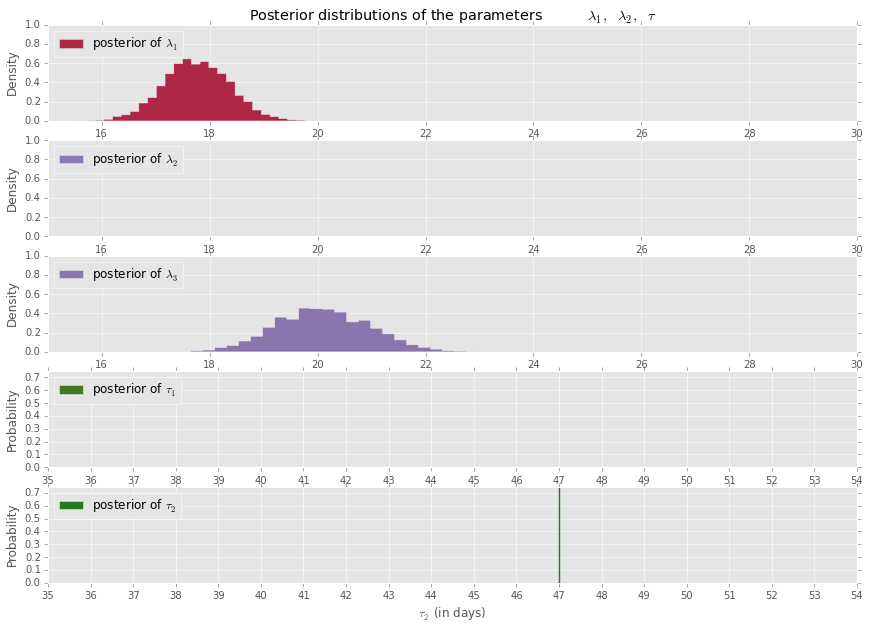

In [81]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]
tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]

fig = plt.figure(figsize=(14.5,10))

#figsize(14.5, 10)
# histogram of the samples 

ax = plt.subplot(511)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters\
          $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")


ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#7A61A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_3$ value")
plt.ylabel("Density")

plt.subplot(514)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)
plt.hist(tau_1_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_1$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau_1$ (in days)")
plt.ylabel("Probability")

plt.subplot(515)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_2_samples)
plt.hist(tau_2_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_2$", color="#267821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau_2$ (in days)")
plt.ylabel("Probability");





## Introduction

This chapter introduces more PyMC syntax and design patterns, and ways to think about hwo to model a system from a Bayesian perspective. It also contains tips and data visualization techniques for assessing goodness of fit for your Bayesian model.

### Parent and Child relationships

To assist with describing Bayesian relationships and to be consistent with PyMCs documentation, we introduce parent and child variables

* **Parent variables** are variables that influence another variable
* **Child variables** are variables that are affected by other variables - that is, are the subject of parent variables.

A variable can be both a parent and a child.

In [82]:
import pymc as pm

lambda_ = pm.Exponential("poisson_param", 1)
# used in the call to the next variable ... 
data_generator = pm.Poisson("data_generator", lambda_)

data_plus_one = data_generator + 1

In [83]:
print "Children of 'lambda_': "
print lambda_.children
print "\n Parents of 'data_generator': "
print data_generator.parents
print "\n Children of 'data_generator': "
print data_generator.children

Children of 'lambda_': 
set([<pymc.distributions.Poisson 'data_generator' at 0x00000000123713C8>])

 Parents of 'data_generator': 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x000000000D24DFD0>}

 Children of 'data_generator': 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x0000000012371AC8>])


In [84]:
print "lambda_.value =", lambda_.value
print "data_generator.value =", data_generator.value
print "data_plus_one.value =", data_plus_one.value

lambda_.value = 0.850685427564
data_generator.value = 0
data_plus_one.value = 1


In [85]:
some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)

The PyMC docs http://pymc-devs.github.com/pymc/distributions.html contain the specific parameters for stochastic variables.
Or use ??  if you are using IPython

For multivariable problems, rather than creating a Python array of stochastic variables, setting the size keyword in the call to a Stochastic variable creates an array of (independent) stochastic variables. The array behaves like a NumPy array when used like one, and references to its value attribute return NumPy arrays.

In [86]:
pm.DiscreteUniform??

In [87]:
betas = pm.Uniform("betas", 0, 1, size=N)

In [88]:
N

30000L

In [89]:
betas[0].value

0.73665905022292533

In [90]:
pm.Exponential??

In [91]:
lambda_1 = pm.Exponential("lambda_1", 1) # prior on first behavior 
lambda_2 = pm.Exponential("lambda_2", 1) # prior on second behavior 
tau = pm.DiscreteUniform("tau", lower=0, upper=10)

In [92]:
print "Initialized values..."
print "lambda_1.value: %.3f " % lambda_1.value
print "lambda_2.value: %.3f " % lambda_2.value
print "tau.value: %.3f " % tau.value
print

Initialized values...
lambda_1.value: 2.013 
lambda_2.value: 0.181 
tau.value: 5.000 



In [93]:
lambda_1.random(), lambda_2.random(), tau.random()

(array(0.2065421230539987), array(0.985939425999655), array(10))

In [94]:
print "After calling random() on the variables..."
print "lambda_1.value: %.3f " % lambda_1.value
print "lambda_2.value: %.3f " % lambda_2.value
print "tau.value: %.3f " % tau.value

After calling random() on the variables...
lambda_1.value: 0.207 
lambda_2.value: 0.986 
tau.value: 10.000 


The call to ```random``` stores a new value into the variable's ```value``` attribute

In [95]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [96]:
type(lambda_1)

pymc.distributions.Exponential

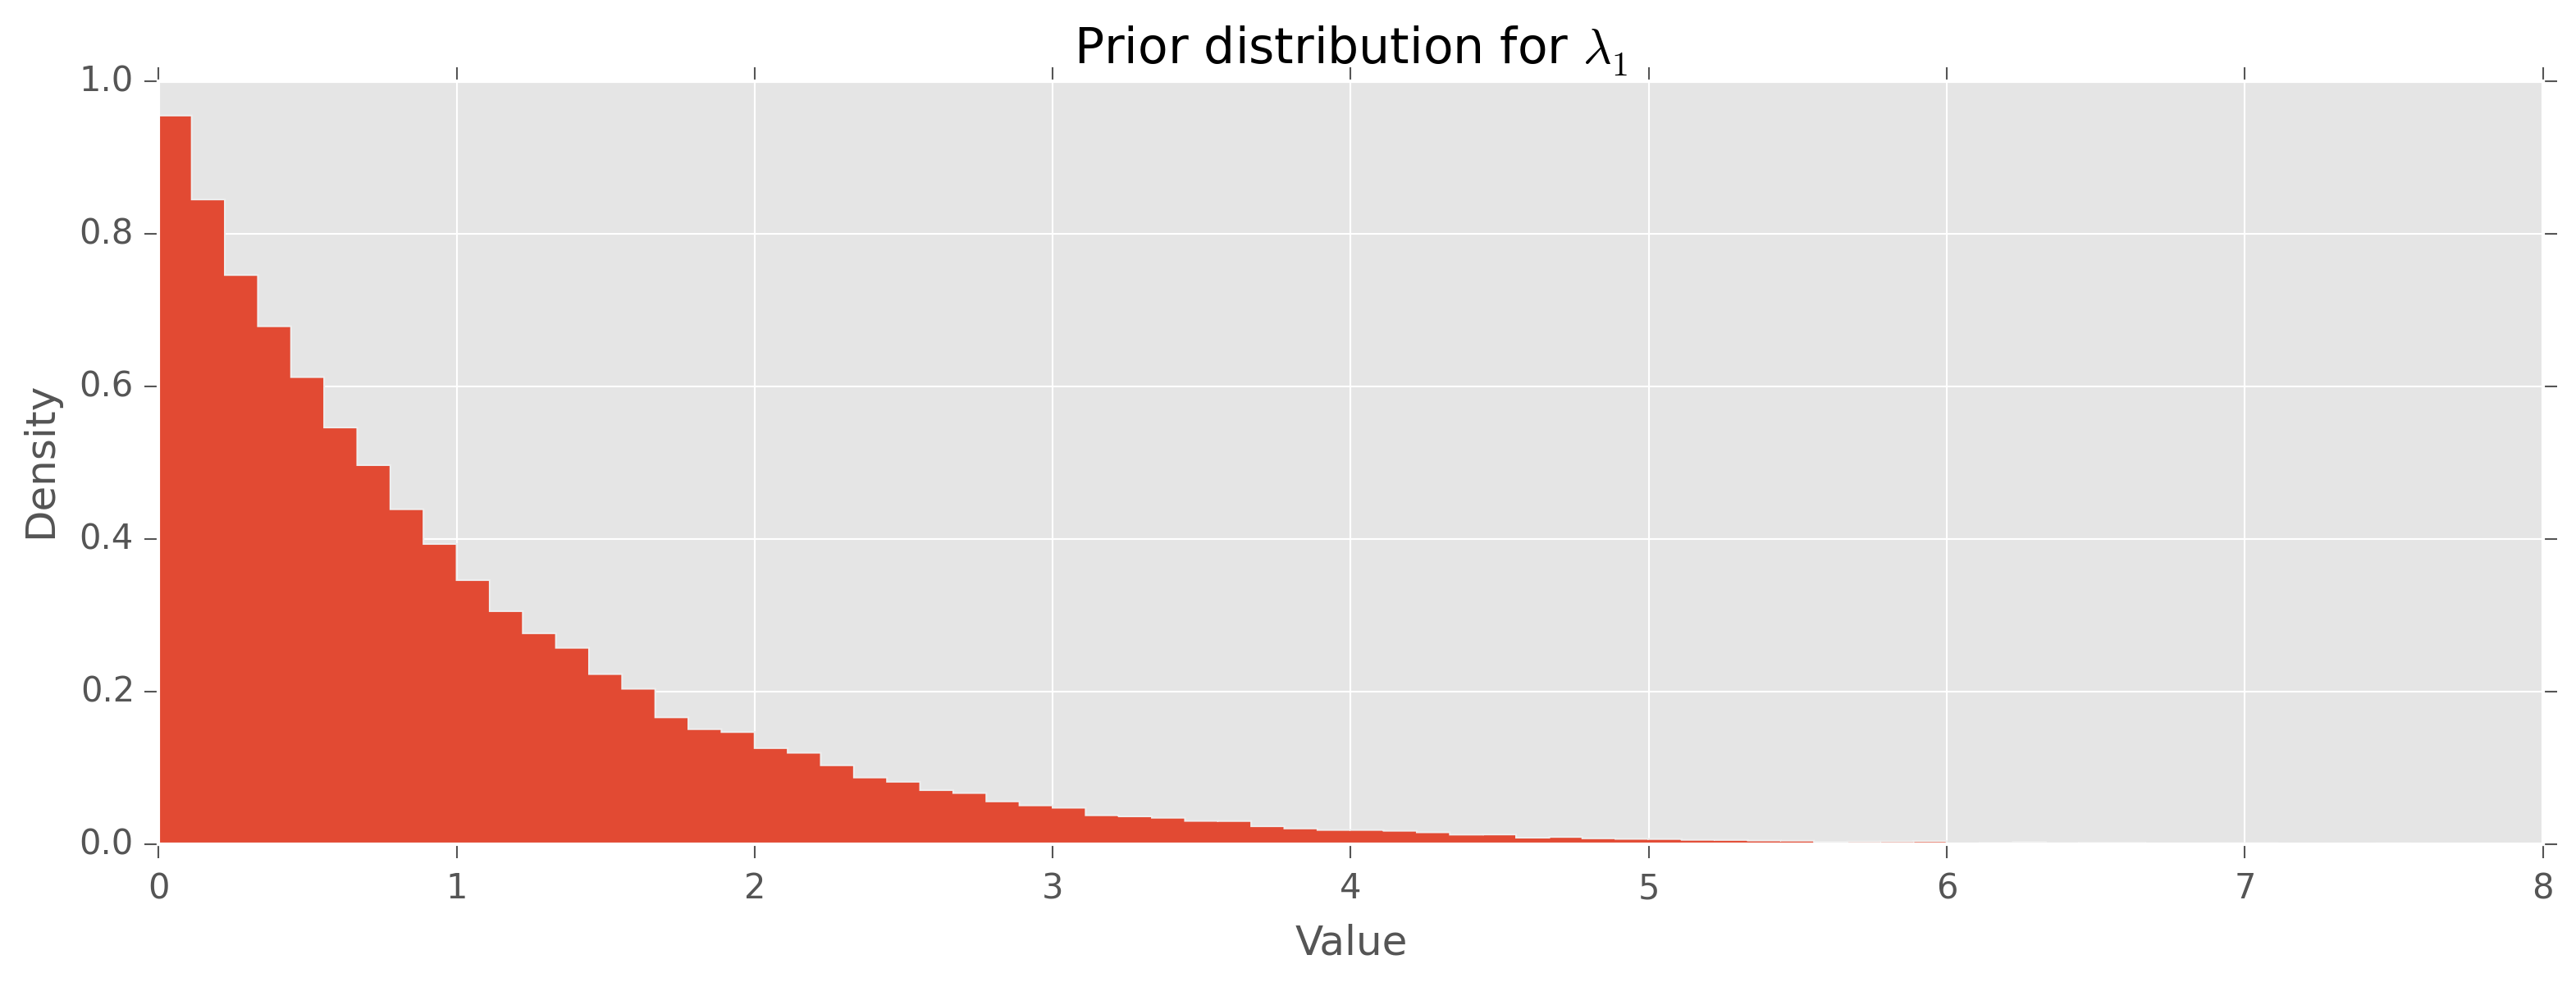

In [97]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
samples = [lambda_1.random() for i in range(50000)]
plt.hist(samples, bins=100, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 8);

In [98]:
data = np.array([10, 5, 15])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print "value: ", fixed_variable.value
print "calling .random()"
fixed_variable.random()
print "value: ", fixed_variable.value

value:  [10  5 15]
calling .random()
value:  [10  5 15]


In [99]:
# We're using some fake data here. 
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


## 2.2 Modeling Approaches

A good starting thought to Bayesian modeling is to think about _how your data might have been generated_. Position yourself as an omnisceint controller, and try to imagine how _you_ would recreate the dataset.

In Chapter 1, we investigated text-message data. We began by asking how our observations may have been generated.

1. We started by thinking, "What is the best random variable to describe this count data?" A Poisson random variable is a good candiate because it can represent count data well. So we model the number of text messages received as sampled from a Poisson distribution.
2. Next, we think, "Okay, assuming text messages are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a parameter $\lambda$
3. Do we know $\lambda$? No. In fact, we have a suspeciion that there are _two_ $\lambda$ values, one for earlier behavior and one for later behavior. We don't know when the behavior switches, though, but call the switchpoint $\tau$.
4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well, the exponential distribution has a parameter too - call it $\alpha$.
5. Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance; whereas we have a prior belief about $\lambda$ ("It probably changes ovedr time," "It's likely between 10 and 30," etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop modeling here.

In [100]:
import daft

PyMC, and other probabilistic programming languages, have been designed to tell these data-generation stories. More generally, Cronin writes:

Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories—thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

In [101]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

17


In [102]:
alpha = 1./20
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

7.02337444656 14.2116872666


In [103]:
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau)]
print lambda_

[  7.02337445   7.02337445   7.02337445   7.02337445   7.02337445
   7.02337445   7.02337445   7.02337445   7.02337445   7.02337445
   7.02337445   7.02337445   7.02337445   7.02337445   7.02337445
   7.02337445   7.02337445  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168727  14.21168727  14.21168727  14.21168727  14.21168727
  14.21168

In [104]:
data = pm.rpoisson(lambda_)
print data

[ 7  5  8  8  8  8  5  6  4  6  4  6  6  9  6 11  5 11 12 18  8 24 12 11 14
  9 12 13  9 14 22  8 21 16 18 13 13 17 14 11 12 15 14 16  9 16 14  7 21  8
 18 10 13 11 14 12 15 17 22 11 11 16 14 12 18 13 13 12  9 14 18 16 17  8  8
 12 10 16  9 17]


In [105]:
artificial = pd.Series(data)

In [106]:
artificial.head()

0    7
1    5
2    8
3    8
4    8
dtype: int32

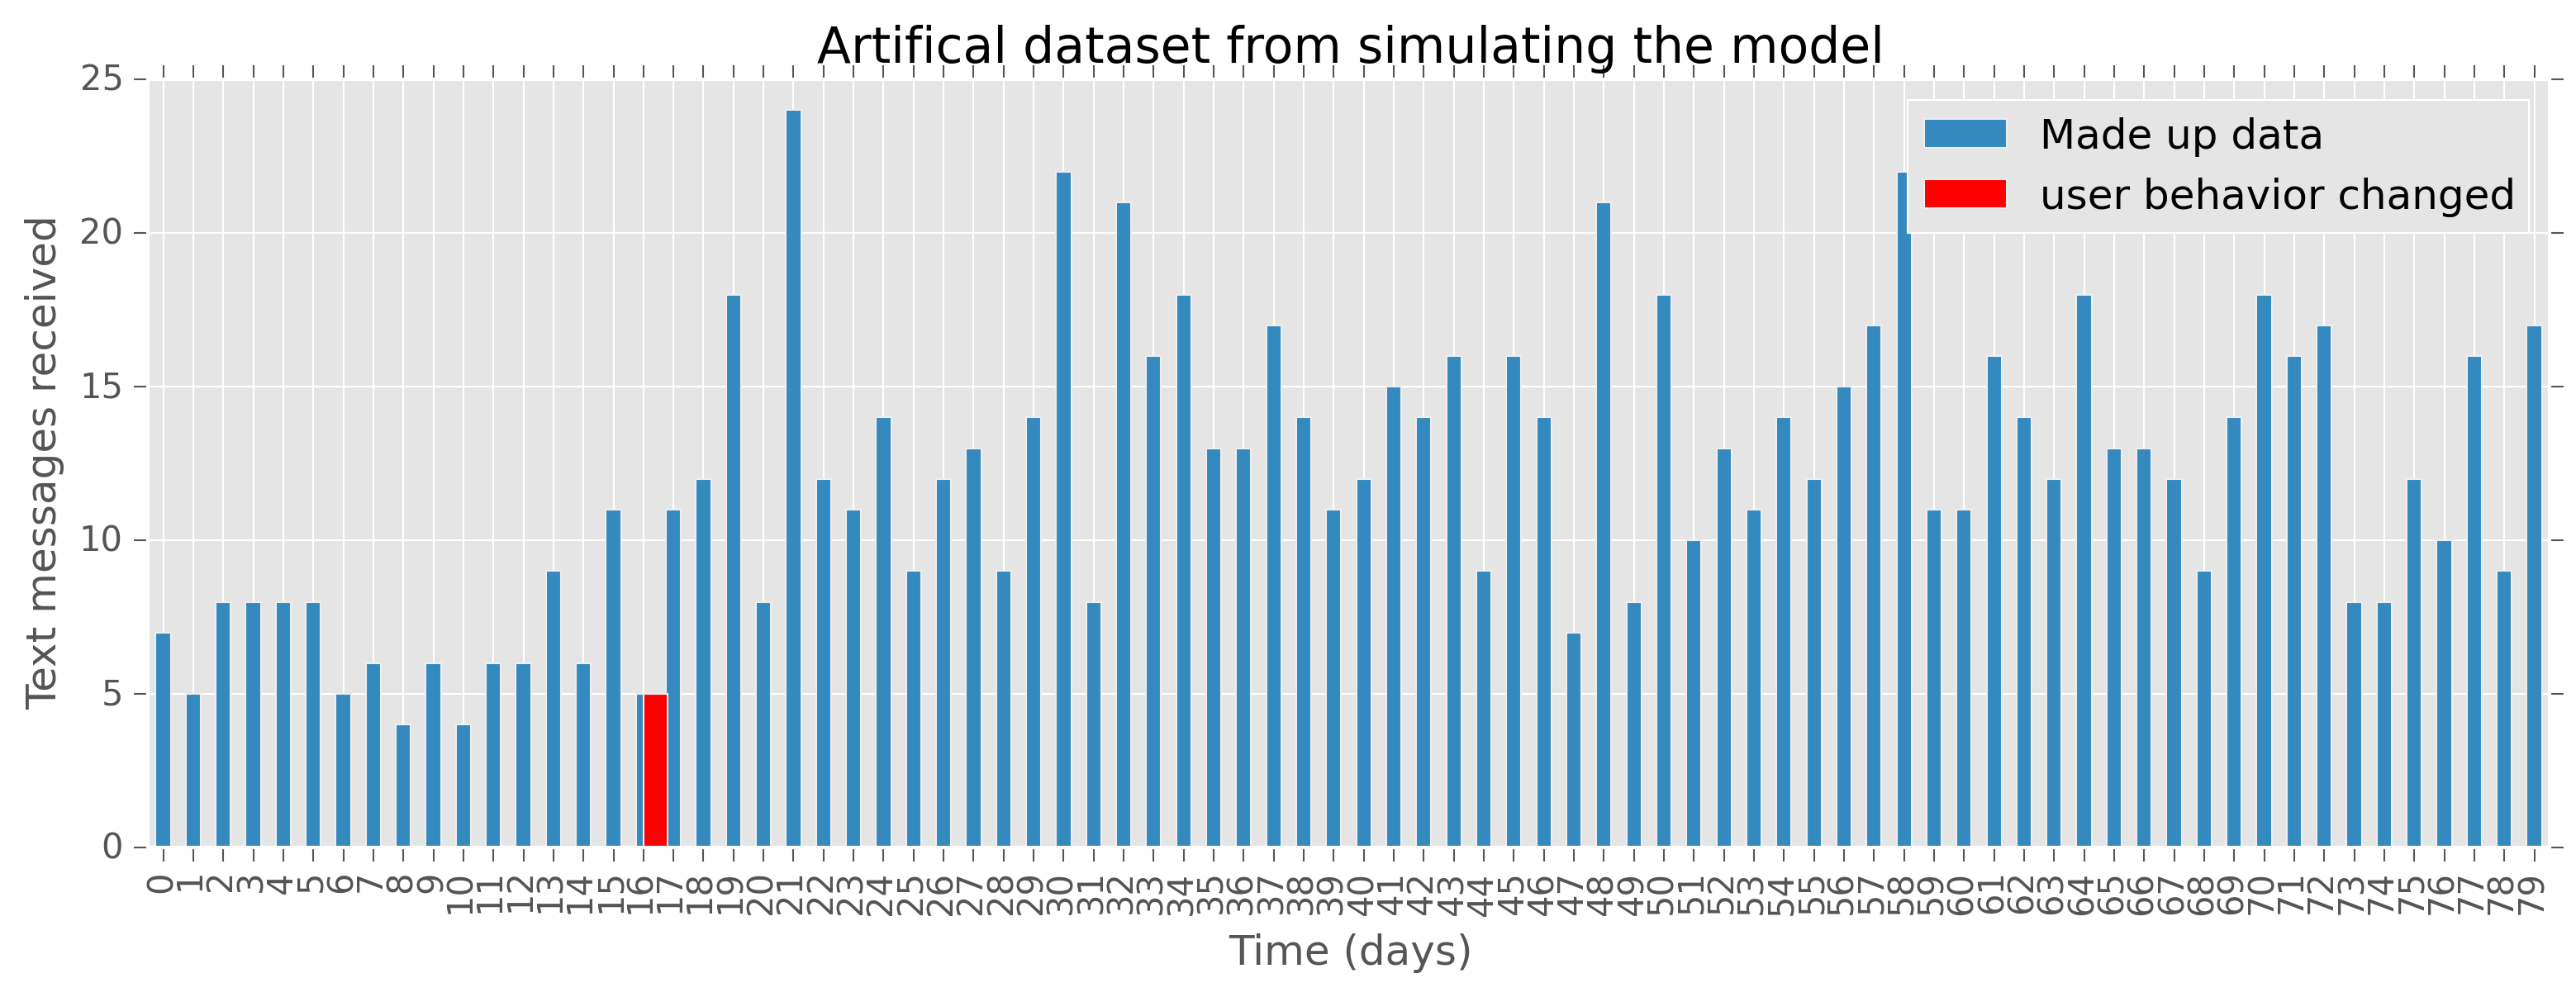

In [107]:
artificial.plot(kind='bar',title="Artifical dataset from simulating the model",
               color="#348ABF",label="Made up data")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.bar(tau-1, data[tau-1],color="r",label="user behavior changed")
plt.legend()


The ability to generate an artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. For example, we’ll produce a few more datasets in Figure 2.2.3.

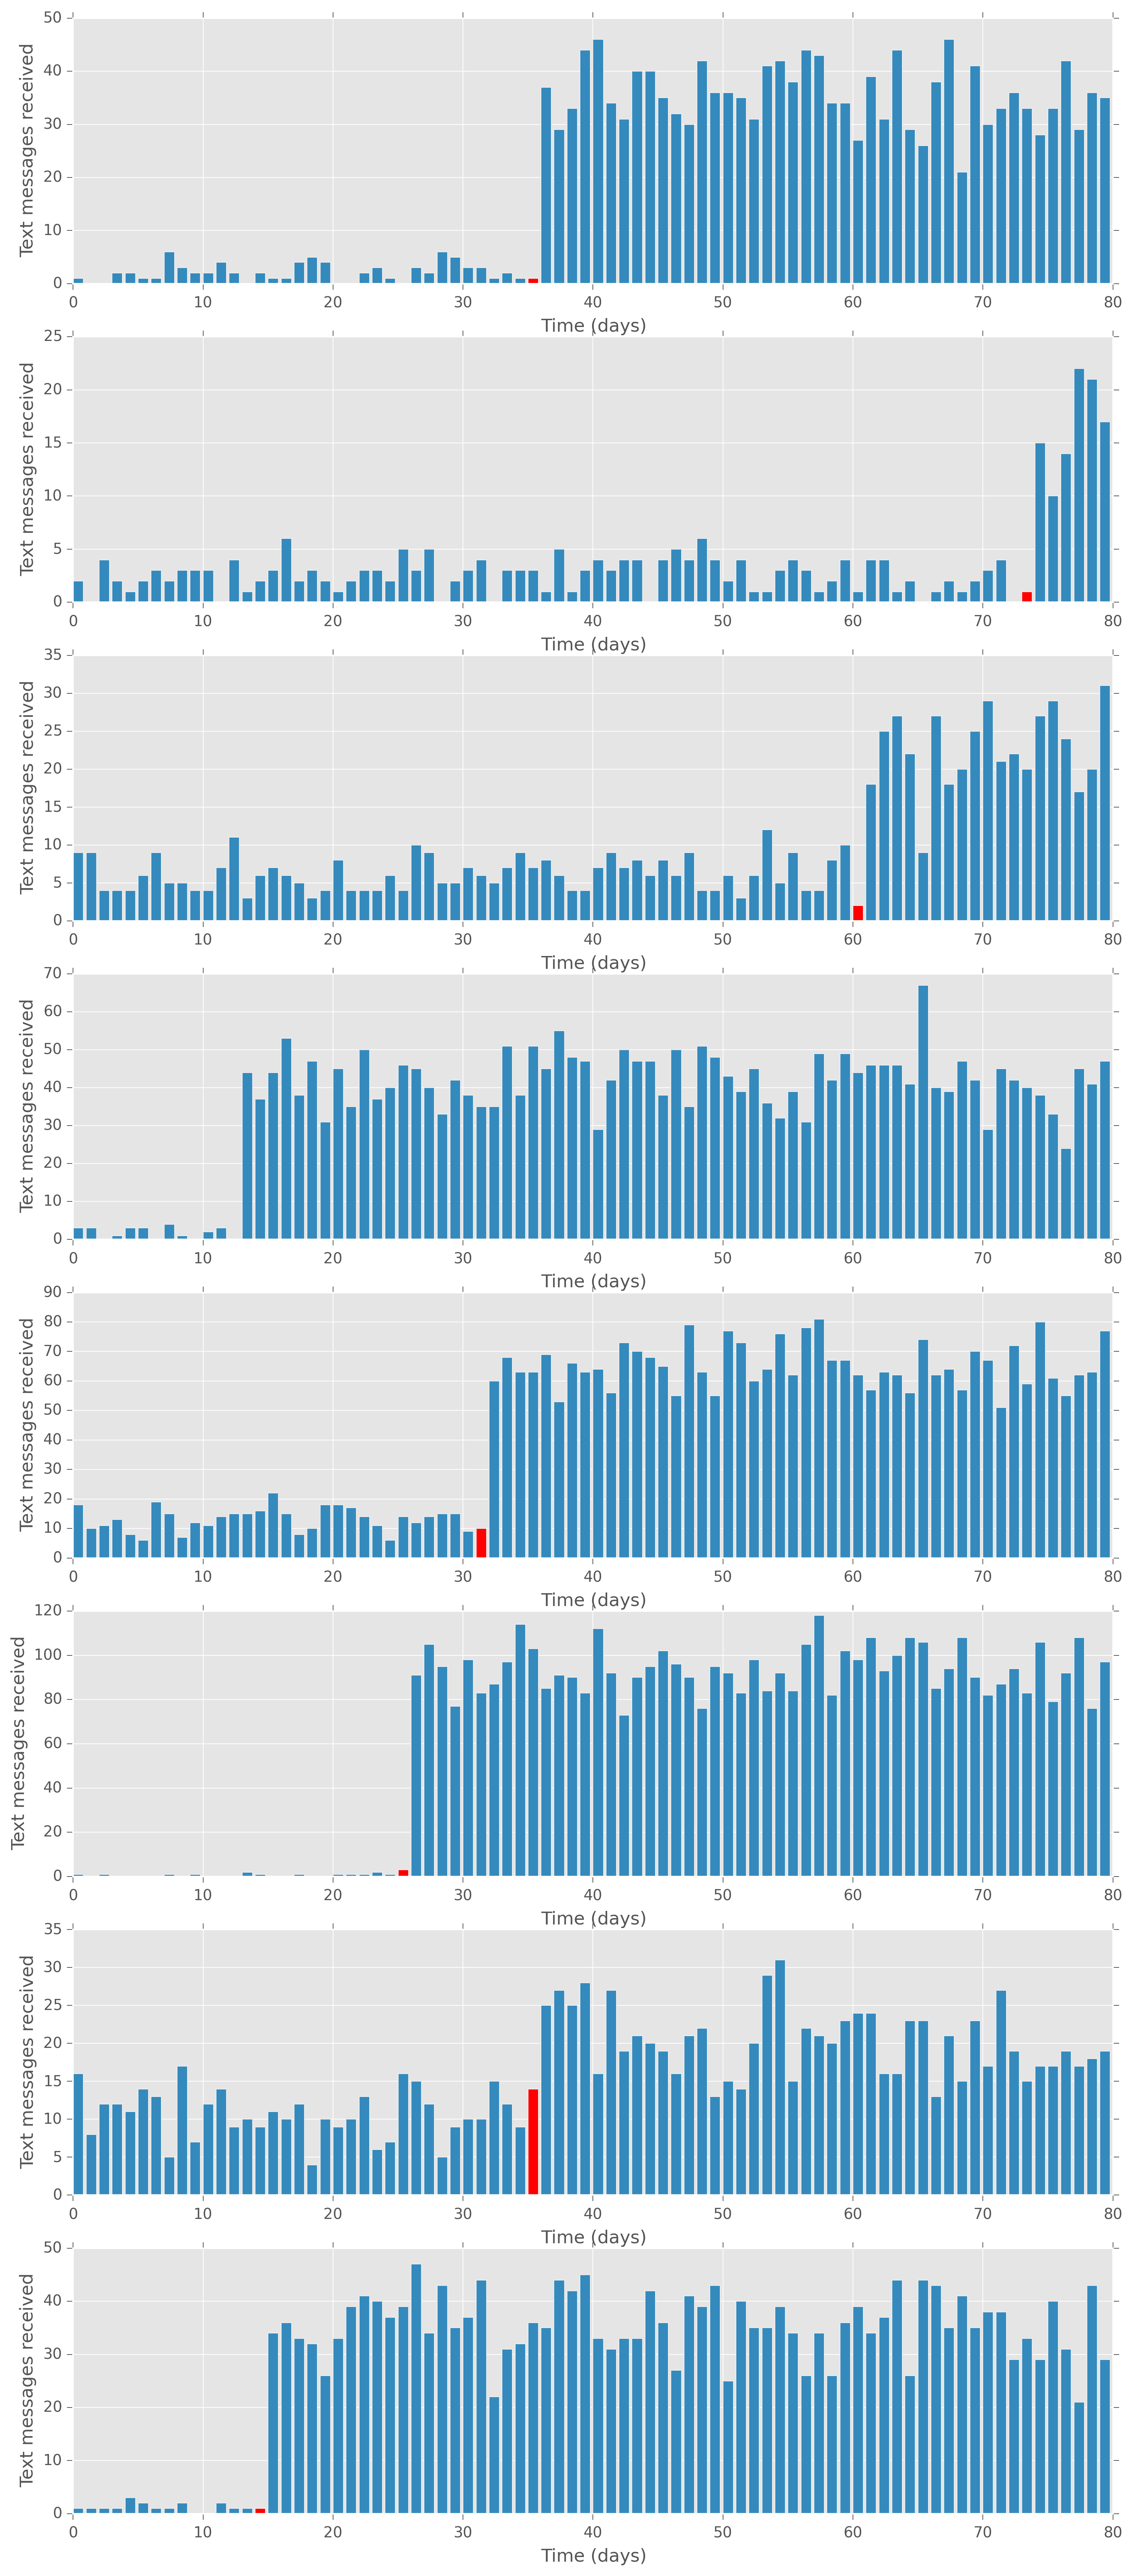

In [108]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2,
                 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r",
            label="user behavior changed")
    plt.xlim(0, 80)
    plt.xlabel("Time (days)")
    plt.ylabel("Text messages received")

figsize(12.5, 30)
plt.title("More examples of artificial datasets from\
          simulating our model")
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.xlabel("Time (days)")
    plt.ylabel("Text messages received")
    plot_artificial_sms_dataset()

Later we will see how we use this to make predictions and test the appropriateness of our models.

## 2.2.2 Example: Bayesian A/B Testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A versus drug B. The company will test drug A on some percentage of a patient group, and drug B on the rest (this split is often 50% / 50%, but we will relax this assumption). After performing enough trials, the in-house statisticians measure the effectiveness to determine which drug yields better results. 


Similarly, front-end Web developers are interested in which design of their Web site yields more conversions, where a conversion could be a visitor signing up, purchasing something, or taking some other action. They will route some fraction of visitors to site A, and the other fraction to site B (which has an alternate design), and record if the visit yielded a conversion or not. The assignments and conversions are recorded and analyzed afterward.

The key value of A/B tests is that there is only a single difference between groups. Thus, any significant change in the metrics (like drug effectiveness or conversions) can be directly attributed to the difference.

Often, the post-experiment analysis is done using something called a “hypothesis test” like a difference of means test or difference of proportions test. This involves often misunderstood quantities like a “Z-score” and even more confusing “p-values” (please don’t ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily learned this technique). And if you were like me, you may have felt uncomfortable with their derivation. If so, good. The Bayesian approach to this problem is much more natural.

## 2.2.3 A Simple Case

As this is a _hacker_ book, we'll continue with the web-development example.For the moment, we will focus on the analysis of site A first. Assume that there is some probability $p_A$ that users who are shown site A eventually convert. This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to N people, and n people converted. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the _observed frequency_ $\frac{n}{N}$ does not necessarily equal $p_A$; there is a difference between the _observed frequency_ and the _true frequency_ of an event. The true frequency can be interpreted as the probability of an event occurring, and this does not necessarily equal the observed frequency. For example, the true frequency of rolling a 1 on a six-sided die is $\frac{1}{6}$, but if we roll the dice six times we may not see a 1 show up at all (the observed frequency)! We must commonly determine the true frequency of events like:

* The fractino of users who make purchases
* the proportion of some characteristic in a population
* the percentage of internet users with cats
* or the probability that it will rain tomorrow

Unfortunately, noise and complexities hide the true frequency from us and we must _infer_ it form observed data. We use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data. With respect to our conversion example, we are interested in using what we know, N (the total visitors) and n (the number of conversions), to estimate what $p_A$, the true frequency of conversion, might be.

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. _A prior_, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [109]:
import pymc as pm

# The parameters are the counds of the Uniform

p = pm.Uniform('p', lower=0, upper=1)

# set constants
p_true = 0.05  # remember, this is uknown in real-life
N = 150000

# Sample N Bernoulli random variables from Ber(0.05)
# Each random variable has a 0.05 chance of being a 1.
# This is the data-generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences # Remember: Python trreats True == 1, and False == 0

print occurrences.sum()

[False False False ..., False False  True]
7473


In [110]:
.05*1500

75.0

In [111]:
# Occurrences.mean() is equal to n/N. 
print "What is the observed frequency in Group A? %.4f "\
                % occurrences.mean()
print "Does the observed frequency equal the true frequency? %s "\
                % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0498 
Does the observed frequency equal the true frequency? False 


In [112]:
# Include the observations, which are Bernoulli. 
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# to be explained in Chapter 3 
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 25.4 sec

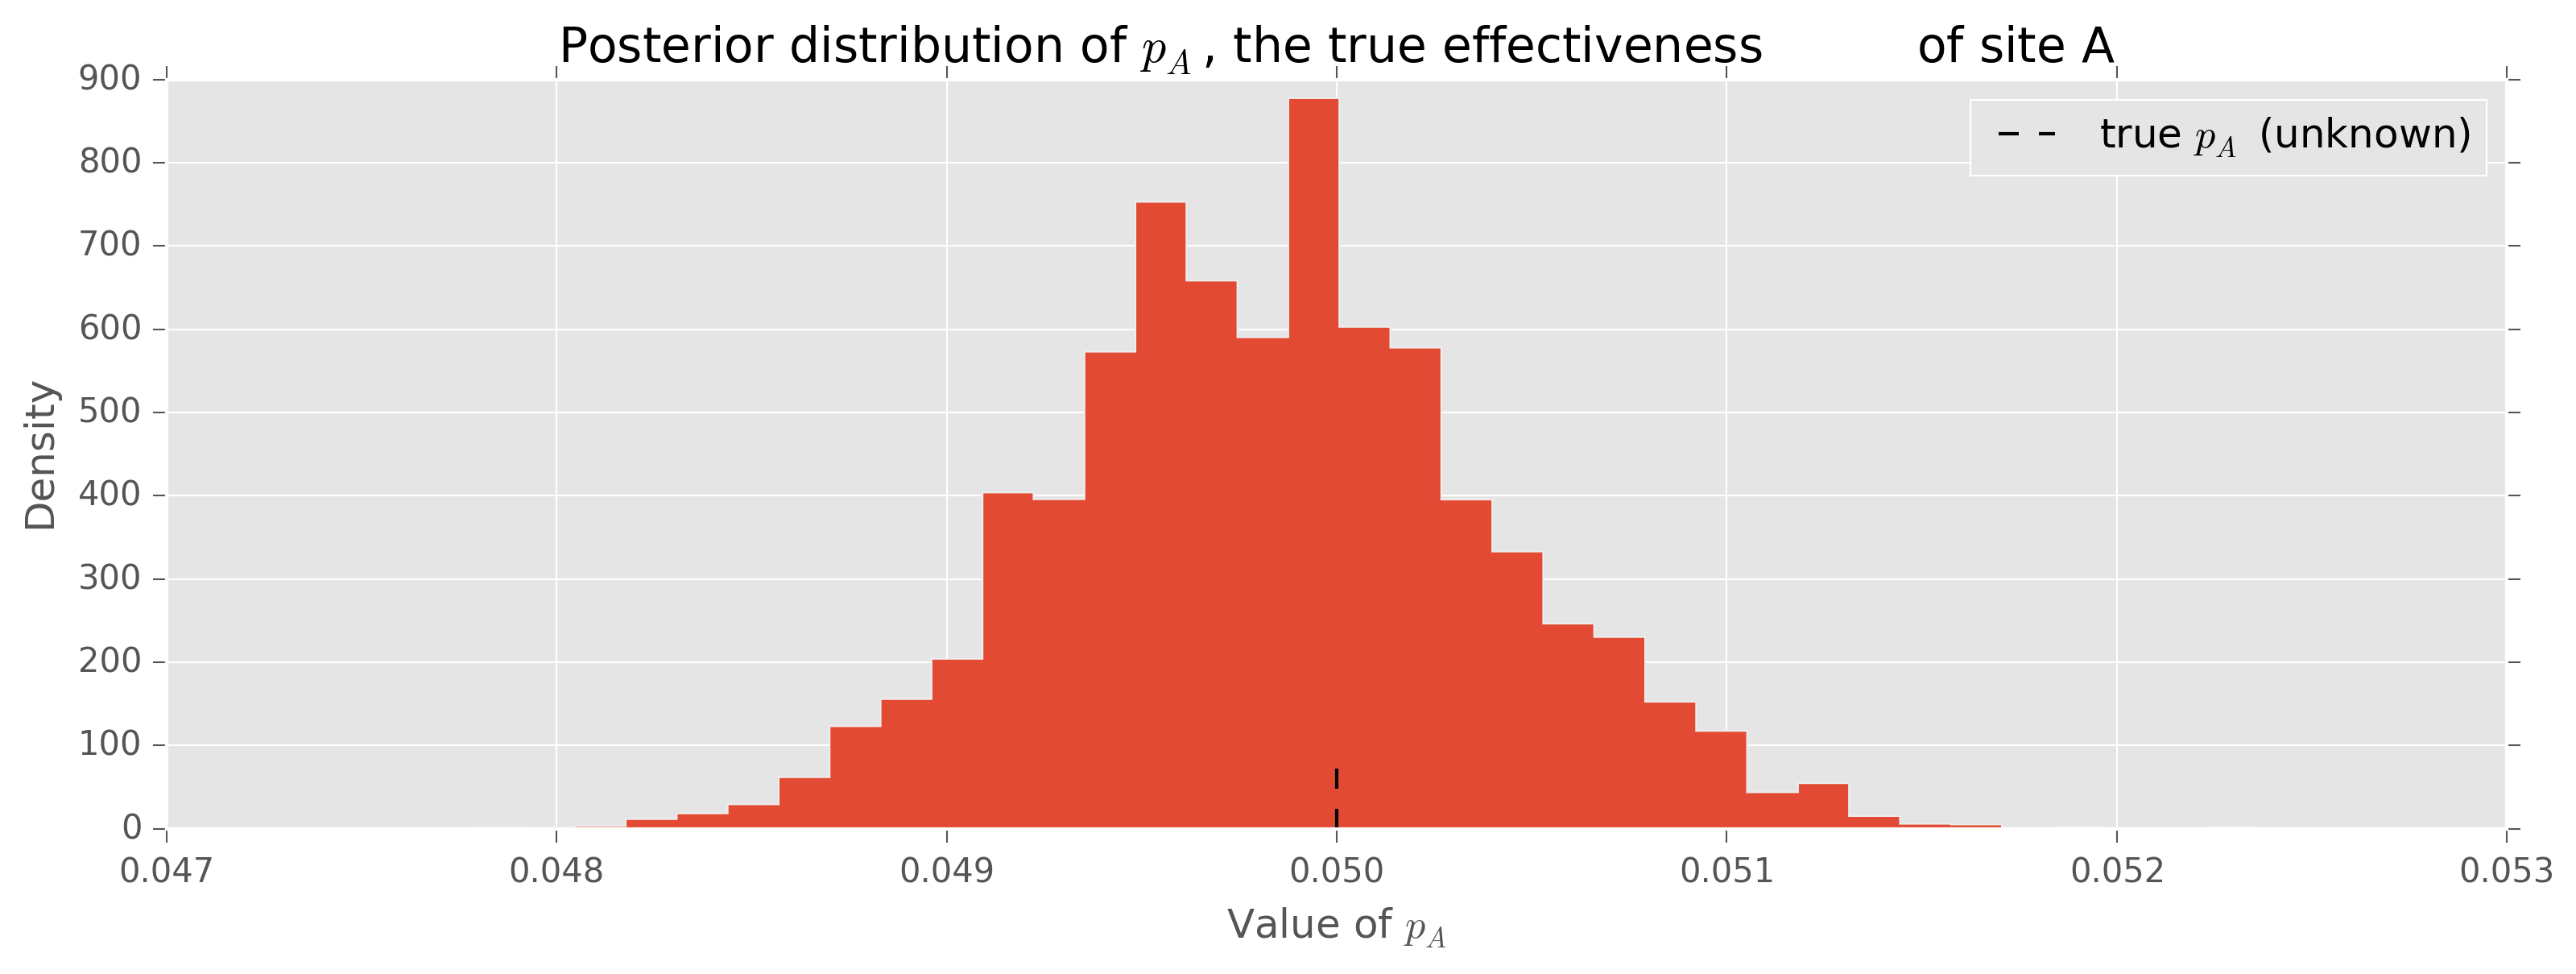

In [113]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness\
          of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled",
         normed=True)
plt.xlabel("Value of $p_A$")
plt.ylabel("Density")
plt.legend();